https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
# import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as ts
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [2]:
dataset = pd.read_csv("pollution.csv")
display(dataset)
print(dataset.info())

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB
None


In [3]:
print(dataset.index)

RangeIndex(start=0, stop=43824, step=1)


In [4]:
# new column named "date"
# parse date information
dataset["date"] = pd.to_datetime(dataset[["year","month","day","hour"]],format ="%Y%m%d%H" )
dataset.drop(["year", "month","day","hour"], axis=1,inplace=True)
dataset["date"]

0       2010-01-01 00:00:00
1       2010-01-01 01:00:00
2       2010-01-01 02:00:00
3       2010-01-01 03:00:00
4       2010-01-01 04:00:00
                ...        
43819   2014-12-31 19:00:00
43820   2014-12-31 20:00:00
43821   2014-12-31 21:00:00
43822   2014-12-31 22:00:00
43823   2014-12-31 23:00:00
Name: date, Length: 43824, dtype: datetime64[ns]

In [5]:
# set new index as "date" and drop "No"
dataset.drop("No",axis=1, inplace=True)
# display(dataset)
dataset.set_index("date",inplace=True)
display(dataset)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [6]:
dataset.columns=['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
display(dataset.head())

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
# fill na values with interpolation and drop first 24 columns
# first 24 values are NA
dataset["pollution"] = dataset["pollution"].interpolate(method="linear")
dataset = dataset[24:]
display(dataset.head())
dataset[dataset.isna().any(axis=1)]

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,


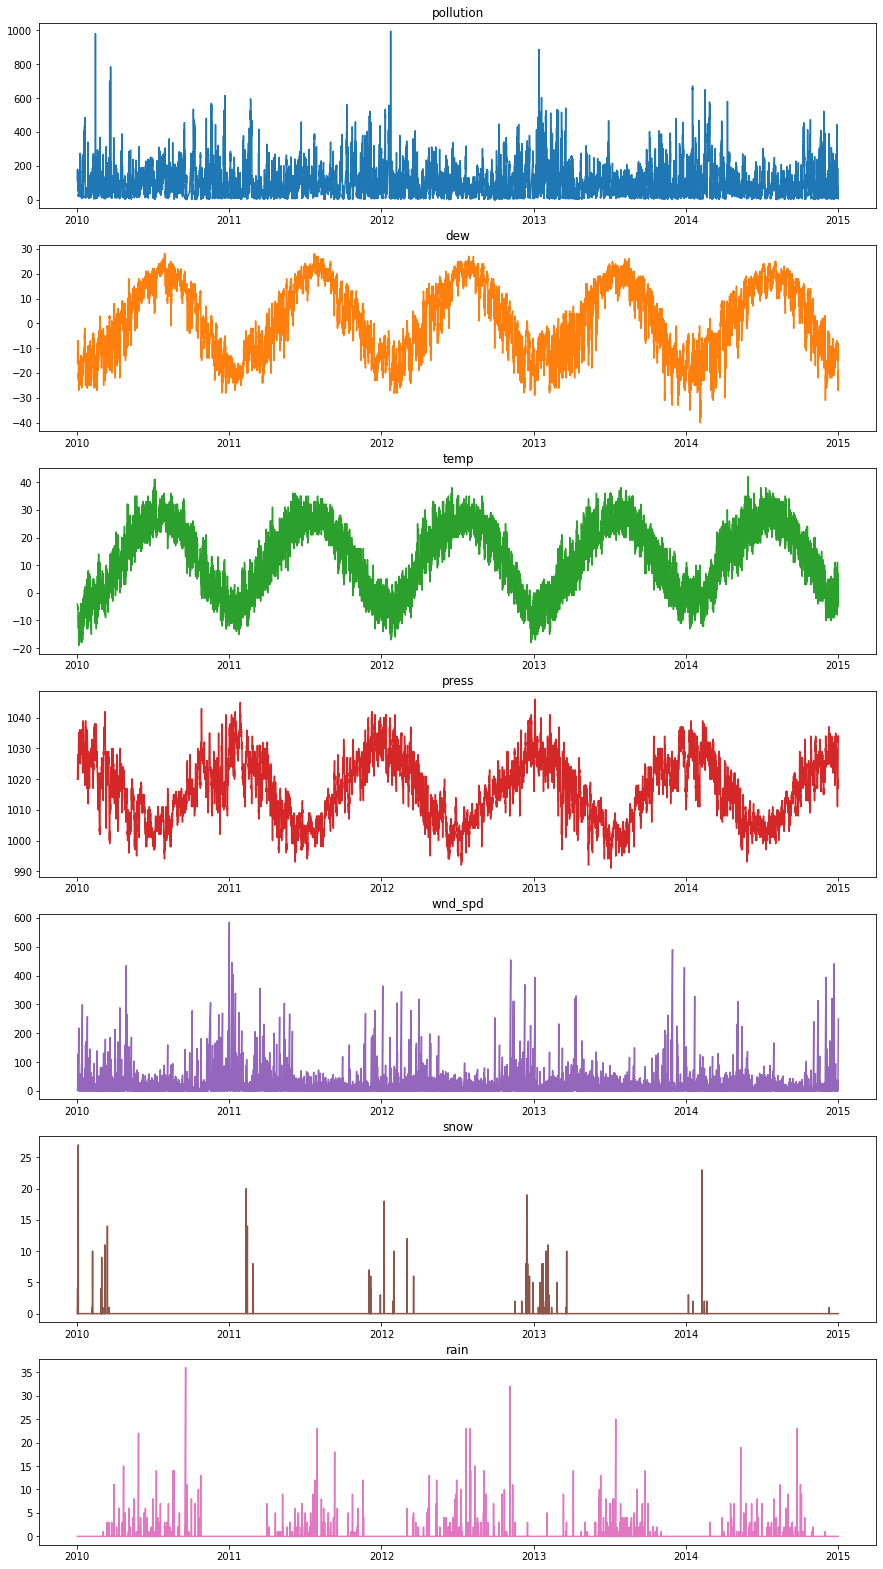

In [8]:
# plot each column separately
colors = plt.rcParams["axes.prop_cycle"]()
groups = [0, 1, 2, 3, 5, 6, 7]
j = 1
plt.figure(figsize=(15,4*7))
for i in groups:
    c = next(colors)["color"]
    plt.subplot(7,1,j)
    plt.title(dataset.columns[i])
    plt.plot(dataset.iloc[:,i], color=c)
    j += 1

In [9]:
# label encoding on wind direction column
le = LabelEncoder()
dataset["wnd_dir"] = le.fit_transform(dataset["wnd_dir"])
display(dataset["wnd_dir"])

date
2010-01-02 00:00:00    2
2010-01-02 01:00:00    2
2010-01-02 02:00:00    2
2010-01-02 03:00:00    2
2010-01-02 04:00:00    2
                      ..
2014-12-31 19:00:00    1
2014-12-31 20:00:00    1
2014-12-31 21:00:00    1
2014-12-31 22:00:00    1
2014-12-31 23:00:00    1
Name: wnd_dir, Length: 43800, dtype: int32

In [10]:
# scale the input data
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(dataset)
# display(data_scaled)
# print(type(data_scaled))

In [11]:
def scaled_transform(X,min_data, max_data, min_range, max_range):
    X_std = (X-min_data)/(max_data-min_data)
    X_sc = X_std * (max_range - min_range) + (min_range)
    return np.array(X_sc)

In [12]:
min_range = -1
max_range = 1
min_data = dataset.values.min()
max_data = dataset.values.max()
print(min_data,max_data)
data_scaled = scaled_transform(dataset,min_data, max_data, min_range, max_range)

-40.0 1046.0


In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
#         print("shift")
#         print(df.iloc[:,0].shift(-i))
        cols.append(df.loc[:,0].shift(-i))
#         print(cols)
        if i == 0:
            names += [('var1(t)')]
        else:
            names += [('var1(t+%d)' % (i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [14]:
lags=5 #input t-1, t-2
n_hours = 2 #output t, t+1, t+2
n_features=8
reframed = series_to_supervised(data_scaled,lags,n_hours)
print("\nReframed")
display(reframed.head())


Reframed


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var1(t+1)
5,-0.688766,-0.955801,-0.933702,0.952118,-0.922652,-0.923039,-0.926335,-0.926335,-0.653775,-0.953959,...,-0.672192,-0.939227,-0.935543,0.955801,-0.922652,-0.914825,-0.922652,-0.926335,-0.725599,-0.732965
6,-0.653775,-0.953959,-0.933702,0.952118,-0.922652,-0.921400,-0.926335,-0.926335,-0.633517,-0.946593,...,-0.725599,-0.939227,-0.937385,0.955801,-0.922652,-0.913186,-0.920810,-0.926335,-0.732965,-0.697974
7,-0.633517,-0.946593,-0.935543,0.953959,-0.922652,-0.919761,-0.926335,-0.926335,-0.593002,-0.939227,...,-0.732965,-0.939227,-0.937385,0.957643,-0.922652,-0.909890,-0.918969,-0.926335,-0.697974,-0.705341
8,-0.593002,-0.939227,-0.935543,0.955801,-0.922652,-0.916464,-0.924494,-0.926335,-0.672192,-0.939227,...,-0.697974,-0.939227,-0.935543,0.959484,-0.922652,-0.906593,-0.926335,-0.926335,-0.705341,-0.683241
9,-0.672192,-0.939227,-0.935543,0.955801,-0.922652,-0.914825,-0.922652,-0.926335,-0.725599,-0.939227,...,-0.705341,-0.941068,-0.937385,0.959484,-0.922652,-0.903297,-0.926335,-0.926335,-0.683241,-0.668508


In [15]:
# split train and test
test_hours =365*24
# print(reframed)
train = reframed.values[:-test_hours,:]
test = reframed.values[-test_hours:,:]
print("Train")
print(train.shape)
print("Test")
print(test.shape)


Train
(35034, 42)
Test
(8760, 42)


In [16]:
# split input and output
X_train, y_train = train[:,:-n_hours], train[:,-n_hours:]
X_test, y_test = test[:,:-n_hours], test[:,-n_hours:]
# print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
# print(y_test)
# reshape [samples, timestep, features]
X_train=X_train.reshape(X_train.shape[0],lags,n_features)
X_test=X_test.reshape(X_test.shape[0],lags,n_features)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
# print(X_train)

(35034, 5, 8) (35034, 2) (8760, 5, 8) (8760, 2)


In [17]:
# design the LSTM model
batch_size = 1

model = Sequential()
model.add(LSTM(16,batch_input_shape=(batch_size, lags,n_features),stateful=True,return_sequences=False))
model.add(Dropout(0.2))
# model.add(LSTM(16,return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(n_hours))
model.compile(optimizer="adam",loss="mse")

In [18]:
# fit network
epochs = 150
train_loss = []
val_loss = []
for i in range(epochs):
    history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_split=0.2, verbose=2, shuffle=False)
    train_loss.append(history.history["loss"])
    val_loss.append(history.history["val_loss"])
    model.reset_states()


28027/28027 - 126s - loss: 0.0092 - val_loss: 0.0030 - 126s/epoch - 5ms/step
28027/28027 - 118s - loss: 0.0046 - val_loss: 0.0027 - 118s/epoch - 4ms/step
28027/28027 - 120s - loss: 0.0043 - val_loss: 0.0026 - 120s/epoch - 4ms/step
28027/28027 - 122s - loss: 0.0042 - val_loss: 0.0024 - 122s/epoch - 4ms/step
28027/28027 - 124s - loss: 0.0041 - val_loss: 0.0025 - 124s/epoch - 4ms/step
28027/28027 - 124s - loss: 0.0041 - val_loss: 0.0023 - 124s/epoch - 4ms/step
28027/28027 - 124s - loss: 0.0040 - val_loss: 0.0023 - 124s/epoch - 4ms/step
28027/28027 - 123s - loss: 0.0040 - val_loss: 0.0022 - 123s/epoch - 4ms/step
28027/28027 - 122s - loss: 0.0039 - val_loss: 0.0022 - 122s/epoch - 4ms/step
28027/28027 - 122s - loss: 0.0040 - val_loss: 0.0022 - 122s/epoch - 4ms/step
28027/28027 - 122s - loss: 0.0039 - val_loss: 0.0023 - 122s/epoch - 4ms/step
28027/28027 - 121s - loss: 0.0039 - val_loss: 0.0023 - 121s/epoch - 4ms/step
28027/28027 - 120s - loss: 0.0039 - val_loss: 0.0023 - 120s/epoch - 4ms/step

28027/28027 - 122s - loss: 0.0037 - val_loss: 0.0021 - 122s/epoch - 4ms/step
28027/28027 - 122s - loss: 0.0036 - val_loss: 0.0022 - 122s/epoch - 4ms/step
28027/28027 - 122s - loss: 0.0036 - val_loss: 0.0022 - 122s/epoch - 4ms/step
28027/28027 - 122s - loss: 0.0036 - val_loss: 0.0022 - 122s/epoch - 4ms/step
28027/28027 - 122s - loss: 0.0037 - val_loss: 0.0022 - 122s/epoch - 4ms/step
28027/28027 - 121s - loss: 0.0036 - val_loss: 0.0021 - 121s/epoch - 4ms/step
28027/28027 - 120s - loss: 0.0036 - val_loss: 0.0022 - 120s/epoch - 4ms/step
28027/28027 - 116s - loss: 0.0036 - val_loss: 0.0021 - 116s/epoch - 4ms/step
28027/28027 - 116s - loss: 0.0036 - val_loss: 0.0021 - 116s/epoch - 4ms/step
28027/28027 - 116s - loss: 0.0036 - val_loss: 0.0022 - 116s/epoch - 4ms/step
28027/28027 - 121s - loss: 0.0036 - val_loss: 0.0023 - 121s/epoch - 4ms/step
28027/28027 - 121s - loss: 0.0037 - val_loss: 0.0022 - 121s/epoch - 4ms/step
28027/28027 - 119s - loss: 0.0036 - val_loss: 0.0022 - 119s/epoch - 4ms/step

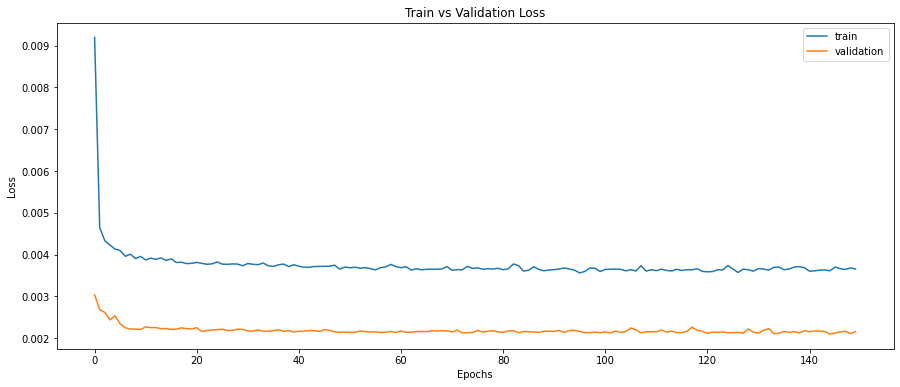

In [19]:
# plot the validation and training loss
plt.figure(figsize=(15,6))
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [20]:
y_pred = model.predict(X_test)

InvalidArgumentError: Graph execution error:

Specified a list with shape [1,8] from a tensor with shape [32,8]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_predict_function_15788778]

In [ ]:
X_test = X_test.reshape(X_test.shape[0],16)
print(y_pred.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred)
print(y_test)

In [ ]:

# inv_pred = np.concatenate((y_pred, X_test[:,-(n_features-n_hours):]), axis=1)
# print(inv_pred.shape)
# inv_pred = scaler.inverse_transform(inv_pred)
# inv_pred = inv_pred[:,0:n_hours]

# inv_test=np.concatenate((y_test,X_test[:,-(n_features-n_hours):]),axis=1)
# inv_test = scaler.inverse_transform(inv_test)
# inv_test = inv_test[:,0:n_hours]

# rmse = mean_squared_error(y_pred, y_test) ** (0.5)
# print('Test RMSE: %.3f' % rmse)

In [ ]:
def inverse_transform(X_scaled,min_data,max_data,min_range,max_range):
    X_std = (X_scaled - (min_range))/(max_range-min_range)
    X = X_std * (max_data - min_data) + min_data
    return X

In [ ]:
inv_pred = np.concatenate((y_pred, X_test), axis=1)
inv_pred = inverse_transform(inv_pred,min_data,max_data,min_range,max_range)
inv_pred = inv_pred[:,0:n_hours]

inv_test=np.concatenate((y_test,X_test),axis=1)
inv_test = inverse_transform(inv_test,min_data,max_data,min_range,max_range)
inv_test = inv_test[:,0:n_hours]

rmse = mean_squared_error(inv_pred, inv_test) ** (0.5)
print('Test RMSE: %.3f' % rmse)

In [ ]:
print("Predicted y")
print(inv_pred)

print("Actual y")
print(inv_test)

In [ ]:
plt.plot(inv_pred[:,0],'b',label="predicted(t)")
plt.plot(inv_test[:,0],'r',label="actual(t)")
plt.legend()
plt.show()